# Pipeline Project

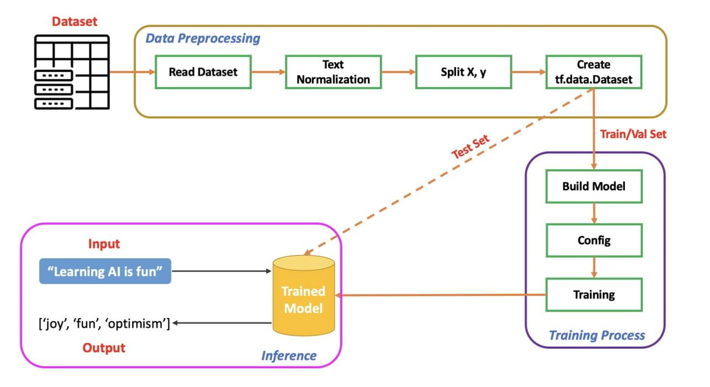

# Dowload Dataset
Dataset: Mutilple Sentiment Analysis (SemEval 2018 Task 1)
https://alt.qcri.org/semeval2018/index.php?id=tasks
https://huggingface.co/datasets/sem_eval_2018_task_1

In [163]:
from datasets import load_dataset

dataset = load_dataset("sem_eval_2018_task_1", 'subtask5.english')

Found cached dataset sem_eval_2018_task_1 (C:/Users/PC/.cache/huggingface/datasets/sem_eval_2018_task_1/subtask5.english/1.1.0/a7c0de8b805f1988b118882fb289ccfbbeb9085c7820b6f046b5887e234af182)


  0%|          | 0/3 [00:00<?, ?it/s]

In [164]:
os.mkdir('Dataset')

In [165]:
dataset['train'].to_csv('Dataset/train.csv')

Creating CSV from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

1231601

In [166]:
dataset['test'].to_csv('Dataset/test.csv')

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

585277

In [167]:
dataset['validation'].to_csv('Dataset/valid.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

159276

# Prepare Dataset

In [168]:
import os
import pandas as pd
ROOT_FOLDER_PATH = 'Dataset'
train_filepath = os.path.join(ROOT_FOLDER_PATH, 'train.csv')
val_filepath = os.path.join(ROOT_FOLDER_PATH, 'valid.csv')
test_filepath = os.path.join(ROOT_FOLDER_PATH, 'test.csv')

train_df = pd.read_csv(train_filepath, index_col=0)
val_df = pd.read_csv(val_filepath, index_col=0)
test_df = pd.read_csv(test_filepath, index_col=0)


In [169]:
import numpy as np
# Find all classname
class_lst = np.array(train_df.columns[2:])
print(class_lst)
n_classes = len(class_lst)
print(f'Number of classes: {n_classes}')
# Find number of saples
n_samples = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
n_samples

['anger' 'anticipation' 'disgust' 'fear' 'joy' 'love' 'optimism'
 'pessimism' 'sadness' 'surprise' 'trust']
Number of classes: 11


10983

# Normalization 

In [170]:
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

english_stopwords = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalization(text):
    # Convert to lower case
    text = text.lower()
    # Convert to ASCII
    text = unidecode.unidecode(text)
    text = text.strip()
    # Remove any special characters and white spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stopwords])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: text_normalization(x)).astype(str)
val_df['Tweet'] = val_df['Tweet'].apply(lambda x: text_normalization(x)).astype(str)
test_df['Tweet'] = test_df['Tweet'].apply(lambda x: text_normalization(x)).astype(str)

In [172]:
train_df['Tweet']

0      worri payment problem may never  joyc meyer  m...
1                      whatev decid make sure make happi
2      max_kellerman  also help major nfl coach inept...
3      accept challeng liter even feel exhilar victor...
4      roommat okay cant spell autocorrect terribl fi...
                             ...                        
833    nicky57672 hi work toward highlight concern ke...
834    andreamitchel said berniesand play hrc campaig...
835    isthataspid dhodg fight guy dont insult lion l...
836                     wonder guy broke peni sex seriou
837               im highli anim even though im decompos
Name: Tweet, Length: 6838, dtype: object

## Split dataframe to set of tweets and set of labels (X, y)

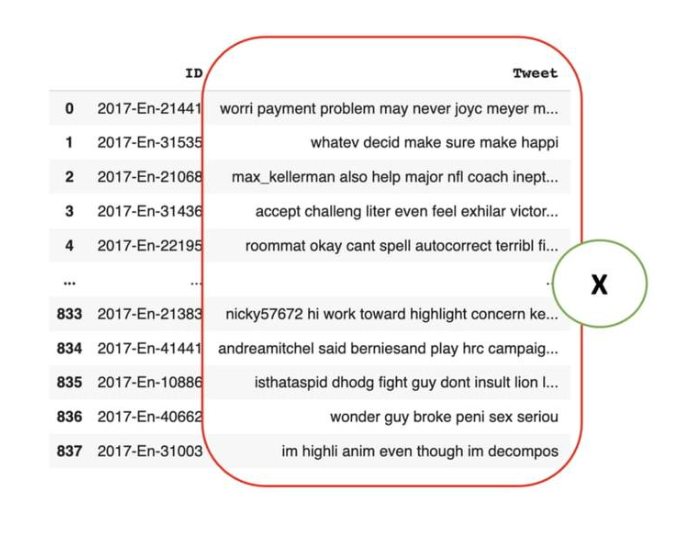

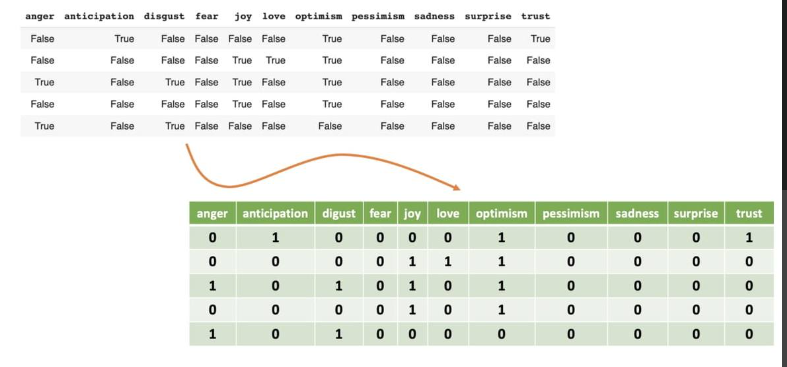

In [173]:
type(y_train)

numpy.ndarray

In [179]:
X_train = train_df['Tweet'].to_numpy()
y_train = train_df[class_lst].astype('int').to_numpy()
X_val = val_df['Tweet'].to_numpy()
y_val = val_df[class_lst].astype('int').to_numpy()
X_test = test_df['Tweet'].to_numpy()
y_test = test_df[class_lst].astype('int').to_numpy()

In [180]:
type(X_train)

numpy.ndarray

## Convert to tf.data.Dataset

In [182]:
import tensorflow as tf
BATCH_SIZE = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

## Buidling Model

In [185]:
MAX_SEQ_LEN = 128
MAX_FEATURES = 5000
EMBEDDING_DIM = 64
text_vectorization_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN
)
train_text = train_ds.map(lambda text, labels: text)
text_vectorization_layer.adapt(train_text)

**Define model architecture**

In [196]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# define model sequential
model = tf.keras.Sequential([
    #input layer is string vector with shape (1,)
    layers.Input(shape=(1,), dtype=tf.string),
    # text vectorization layer
    text_vectorization_layer,
    #Embedding layer
    layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),
    # Bidirectional LSTM layer 1 return vector ouput of time step to input to next layer bidirectional
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Bidirectional LSTM layer 2 return hidden state of last time step
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Bidirectional LSTM layer 3 return vector ouput of time step
    layers.Bidirectional(layers.LSTM(64)),
    # Dropout layer 1 with 0.2 rate
    layers.Dropout(0.2),
    # Full connected layer 1 with 64 units with relu activation
    layers.Dense(64, activation='relu'),
    # Dropout layer 2 with 0.3 rate
    layers.Dropout(0.3),
    # Full connected layer 2 with 32 units with relu activation
    layers.Dense(32, activation='relu'),
])

In [198]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 128, 64)           320000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 128, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 128, 128)         98816     
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 128)              98816     
 onal)                                                

In [199]:
threshold = 0.5
 # create inverse_label function with class_lst and threshold_pred as input
def inverse_label(class_lst, label):
    return ', '.join([class_lst[i] for i in range(len(class_lst)) if label[i] == 1])
for text_batch, label_batch in test_ds.take(1):
    for i in range(10):
        input_text = text_batch[i].numpy()
        label = label_batch[i].numpy()
        pred = model.predict(np.expand_dims(input_text, axis=0), verbose=0)[0]
        thresholded_pred = np.where(pred > threshold, 1, 0)
        print(f'Input text: {input_text}')    
        print(f'Label: {inverse_label(class_lst, label)}')
        print(f'Predicted label(s): ({inverse_label(class_lst, thresholded_pred)})')
        print(" ")

Input text: b'adnan__786__ asyounotwish dont worri indian armi way dispatch terrorist hell'
Label: anger, anticipation, optimism, trust
Predicted label(s): ()
 
Input text: b'academi scienc eschew normal sober tone scientif paper call massiv loss wildlif biolog annihil'
Label: disgust
Predicted label(s): ()
 
Input text: b'blew opportun __ mad'
Label: anger, disgust, sadness
Predicted label(s): ()
 
Input text: b'time 2 week 30'
Label: joy, sadness
Predicted label(s): ()
 
Input text: b'deppress real partner w depress peopl truli dont understand depth affect us add anxieti ampmak wors'
Label: fear, sadness
Predicted label(s): ()
 
Input text: b'politicoeurop interest choic word confirm govern fund terror bit open door still'
Label: anger, disgust, fear, pessimism
Predicted label(s): ()
 
Input text: b'ananavarro cnn sure'
Label: joy, optimism
Predicted label(s): ()
 
Input text: b'distanc stretch friend impos seriou lovey notseri'
Label: love
Predicted label(s): ()
 
Input text: b'happ